# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 034250043_206260762 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

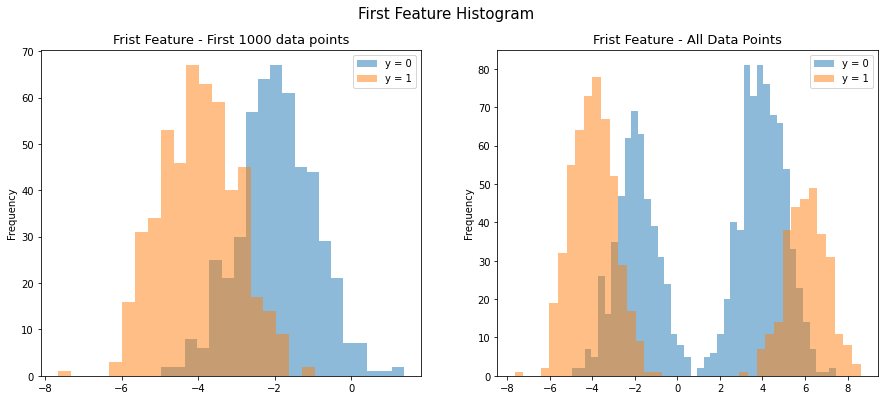

In [4]:
#### Your code here ####
fig, ax = plt.subplots(1,2, figsize=(15,6))
training_set.head(1000)[training_set["y"]==0]['x1'].plot(kind="hist", bins=20, alpha=0.5, ax=ax[0], label='y = 0')
training_set.head(1000)[training_set["y"]==1]['x1'].plot(kind="hist", bins=20, alpha=0.5, ax=ax[0], label='y = 1')

training_set[training_set["y"]==0]['x1'].plot(kind="hist", bins=40, alpha=0.5, ax=ax[1], label='y = 0')
training_set[training_set["y"]==1]['x1'].plot(kind="hist", bins=40, alpha=0.5, ax=ax[1], label='y = 1')

plt.suptitle("First Feature Histogram", size=15)
ax[1].set_title("Frist Feature - All Data Points", size=13)
ax[0].set_title("Frist Feature - First 1000 data points", size=13)
ax[0].legend(), ax[1].legend();

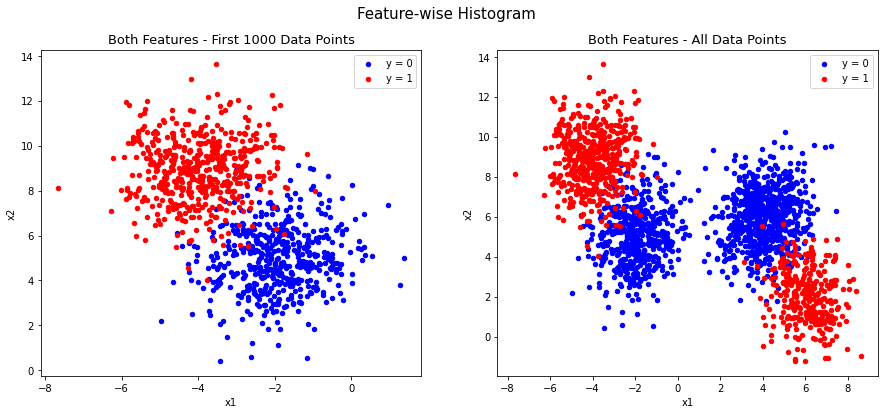

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
training_set.head(1000)[training_set["y"]==0].plot(kind="scatter", ax=ax[0], x="x1", y="x2", color="blue", label="y = 0")
training_set.head(1000)[training_set["y"]==1].plot(kind="scatter", ax=ax[0], x="x1", y="x2", color="red", label="y = 1")

training_set[training_set["y"]==0].plot(kind="scatter", ax=ax[1], x="x1", y="x2", color="blue", label="y = 0")
training_set[training_set["y"]==1].plot(kind="scatter", ax=ax[1], x="x1", y="x2", color="red", label="y = 1")

plt.suptitle("Feature-wise Histogram", size=15)
ax[0].set_title("Both Features - First 1000 Data Points", size=13)
ax[1].set_title("Both Features - All Data Points", size=13)
ax[0].legend(), ax[1].legend();

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD():
    
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.J_history = []
        self.theta = np.empty([])

    def sigmoid(self, X, theta):
        """
        compute the hypothesis
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        theta: {array-like}, shape = [n_features]
            Weights of the model
        """
        return 1 / (1 + np.exp(-X @ theta))            

    def compute_cost(self, X, y, theta):
        """
        compute the loss function of the model againts a Training set
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        theta: {array-like}, shape = [n_features]
            Weights of the model
        """
        h = self.sigmoid(X, theta)
        return (1 / X.shape[0]) * (((-y) @ np.log(h)) - ((1 - y) @ np.log(1-h)))
                    
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        np.random.seed(self.random_state)
        self.J_history = []
        X = np.c_[np.ones(X.shape[0]), X]
        self.theta = np.random.random(size=X.shape[1])
        self.J_history.append(self.compute_cost(X, y, self.theta))
        for i in range(1, self.n_iter):                    
            self.theta -= self.eta * ((self.sigmoid(X, self.theta) - y) @ X)        
            self.J_history.append(self.compute_cost(X, y, self.theta))
            if abs(self.J_history[i-1] - self.J_history[i]) < self.eps:
                break

    def predict(self, X):
        """Return the predicted class label"""
        
        X = np.c_[np.ones(X.shape[0]), X]
        return (self.sigmoid(X, self.theta) > 0.5) * 1
    
    def accuracy(self, X, y):
        """
        compute the accuracy of the model againts a test set
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Test vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Test Target values.
        """
        results = self.predict(X)
        return (results == y).sum()/y.shape[0]

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
%%time
np.random.seed(42)

etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
k=5
fold_size = training_set.shape[0] // k

#Shuffling the training set before split
training_set_shuffled = training_set.sample(frac=1).reset_index(drop=True)
results = {}
for eta in etas:
    for eps in epss:
        accuracy_list = []
        LR_predictor = LogisticRegressionGD(eta = eta, eps = eps)
        for i in range(k):
            start_index = i*fold_size
            stop_index = start_index + fold_size
            validation_set = training_set_shuffled[start_index:stop_index]
            # removing the validation_set samples from the training
            train_set = training_set_shuffled.drop(validation_set.index)
            #defining the training and validation sets
            X_train, y_train = train_set.drop('y', axis=1).values, train_set['y'].values                              
            X_validation, y_validation = validation_set.drop('y', axis=1).values, validation_set['y'].values

            LR_predictor.fit(X_train, y_train)
            accuracy_list.append(LR_predictor.accuracy(X_validation, y_validation))
        results[(eta,eps)] = sum(accuracy_list) / len(accuracy_list)
        

Wall time: 2min 51s


In [8]:
best_eta, best_eps = max(results, key = results.get) 
print(f'The optimal hyper paramers combination is best learning rate: {best_eta:f} with epsilon value: {best_eps:f}')
print(f'Resulting with accuracy of: {results[(best_eta,best_eps)]}')

The optimal hyper paramers combination is best learning rate: 0.000050 with epsilon value: 0.000001
Resulting with accuracy of: 0.7950000000000002


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [9]:
def normal_pdf(data, mu, sigma):
    e_coefficient =  -(data - mu)**2 / (2*sigma**2)
    return np.exp(e_coefficient) / np.sqrt(2*np.pi*(sigma**2))  
pdf_func = np.vectorize(normal_pdf)

In [10]:
def calc_gmm_pdf(X, distributions):
    gmm_pdf = np.zeros(X.shape[0])
    for dist in distributions.values():
        gmm_pdf += pdf_func(X, dist['mu'], dist['std']) * dist['w']
    return gmm_pdf

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [11]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.dists = {}
        self.J_history = []

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        quantile = 0.25
        for k in range(self.k):
            self.dists[k] = {'mu': np.quantile(data, quantile), 'std': data.std()/self.k, 'w': 1/self.k}
            quantile = abs(1-quantile)
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        self.responsiblities = np.zeros([data.shape[0], self.k])
        for idx, dist in enumerate(self.dists.values()):
            self.responsiblities[:,idx] = pdf_func(data, dist['mu'], dist['std']) * dist['w']
    
        self.responsiblities =  (self.responsiblities.T/ self.responsiblities.sum(axis=1)).T       

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        for idx, dist in enumerate(self.dists.values()):
            dist['w'] = self.responsiblities[:,idx].mean()
            dist['mu'] = (1/(dist['w']* data.shape[0])) * (self.responsiblities[:,idx] @ data)
            dist['std'] = (1/(dist['w']* data.shape[0])) * (self.responsiblities[:,idx] @ ((data - dist['mu']) ** 2))                                                               
                                                                
    def fit(self, data):                                                              
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        self.J_history.append(-np.log(calc_gmm_pdf(data, self.dists)).sum())
        for i in range(1, self.n_iter):
            self.J_history.append(-np.log(calc_gmm_pdf(data, self.dists)).sum())
            self.expectation(data)
            self.maximization(data)
            if abs(self.J_history[i-1] - self.J_history[i]) < self.eps:
                break
                
    def get_dist_params(self):
        return self.dists
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [12]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=1):
        self.k = k
        self.random_state = random_state
        self.dists = {}
        self.priors = {}
        self.labels = []
        self.features_num = 0
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.labels = np.unique(y).astype(int)
        self.features_num = X.shape[1]
        for label in self.labels:
            filter_data_by_label = X[y == label]
            self.priors[label] = filter_data_by_label.shape[0] / X.shape[0]
            self.dists[label] = {}
            for feature_num in range(self.features_num):
                gmm = EM(k=self.k)
                gmm.fit(filter_data_by_label[:,feature_num])
                self.dists[label][feature_num] = gmm.get_dist_params()
    
    def predict(self, X):
        """Return the predicted class label"""
        posteriors = np.zeros([X.shape[0], self.labels.shape[0]])
        for label in self.labels:
            posteriors[:,label] += np.log(self.priors[label])
            for feature in range(self.features_num):
                feature_likelihood = calc_gmm_pdf(X[:, feature], self.dists[label][feature])
                posteriors[:,label] += np.log(feature_likelihood)          
        return posteriors.argmax(axis=1)
    
    def accuracy(self, X, y):
        """
        compute the accuracy of the model againts a test set
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Test vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Test Target values.
        """
        return (self.predict(X) == y).sum()/X.shape[0]

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [13]:
LR_Classifier = LogisticRegressionGD(eta = best_eta, eps = best_eps)
LR_Classifier.fit(X_training[:1000], y_training[:1000])
print(f"The Training accuracy of the Logistic Regression Classifier is:{LR_Classifier.accuracy(X_training[:1000], y_training[:1000])}")
print(f"The Test accuracy of the Logistic Regression Classifier is:{LR_Classifier.accuracy(X_test[:500], y_test[:500])}")

NB_Classifier = NaiveBayesGaussian(k=2)
NB_Classifier.fit(X_training[:1000], y_training[:1000])
print(f"\nThe Training accuracy of the Naive Bayes Classifier is:{NB_Classifier.accuracy(X_training[:1000], y_training[:1000])}")
print(f"The Test accuracy of the Naive Bayes Classifier is:{NB_Classifier.accuracy(X_test[:500], y_test[:500])}")


The Training accuracy of the Logistic Regression Classifier is:0.965
The Test accuracy of the Logistic Regression Classifier is:0.938

The Training accuracy of the Naive Bayes Classifier is:0.961
The Test accuracy of the Naive Bayes Classifier is:0.942


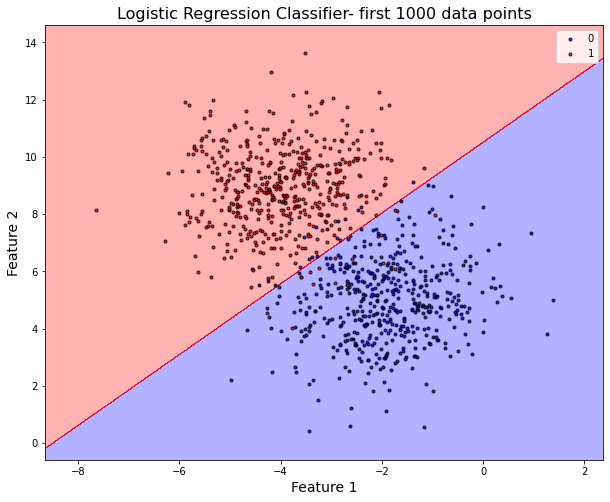

In [14]:
plot_decision_regions(X_training[:1000], y_training[:1000], LR_Classifier, resolution=0.01)
plt.xlabel('Feature 1', fontsize = 14)
plt.ylabel('Feature 2', fontsize = 14)
plt.title('Logistic Regression Classifier- first 1000 data points', size = 16)
plt.legend();

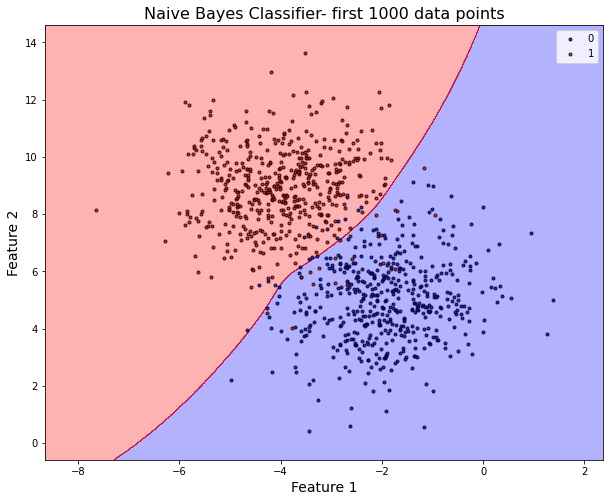

In [15]:
plot_decision_regions(X_training[:1000], y_training[:1000], NB_Classifier, resolution=0.01)
plt.xlabel('Feature 1', fontsize = 14)
plt.ylabel('Feature 2', fontsize = 14)
plt.title('Naive Bayes Classifier- first 1000 data points', size = 16)
plt.legend();

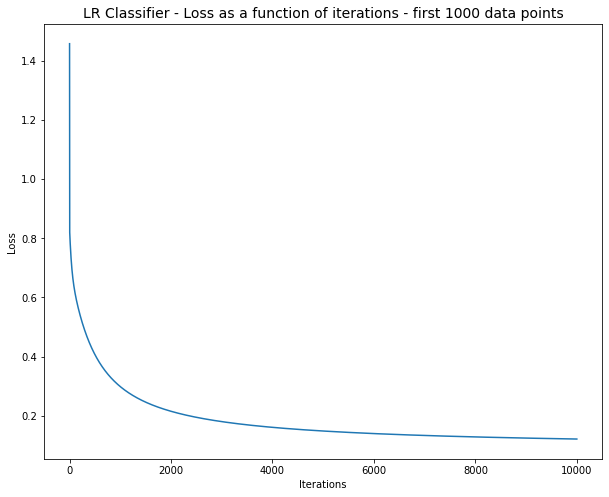

In [16]:
plt.plot(np.arange(len(LR_Classifier.J_history)), LR_Classifier.J_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('LR Classifier - Loss as a function of iterations - first 1000 data points', fontsize = 14)
plt.show()

In [17]:
LR_Classifier = LogisticRegressionGD(eta = best_eta, eps = best_eps)
LR_Classifier.fit(X_training, y_training)
print(f"The Training accuracy of the Logistic Regression Classifier is:{LR_Classifier.accuracy(X_training, y_training)}")
print(f"The Test accuracy of the Logistic Regression Classifier is:{LR_Classifier.accuracy(X_test, y_test)}")
NB_Classifier = NaiveBayesGaussian(k=2)
NB_Classifier.fit(X_training, y_training)
NB_Classifier.accuracy(X_test, y_test)
print(f"\nThe Training accuracy of the Naive Bayes Classifier is:{NB_Classifier.accuracy(X_training, y_training)}")
print(f"The Test accuracy of the Naive Bayes Classifier is:{NB_Classifier.accuracy(X_test, y_test)}")

The Training accuracy of the Logistic Regression Classifier is:0.809
The Test accuracy of the Logistic Regression Classifier is:0.804

The Training accuracy of the Naive Bayes Classifier is:0.916
The Test accuracy of the Naive Bayes Classifier is:0.899


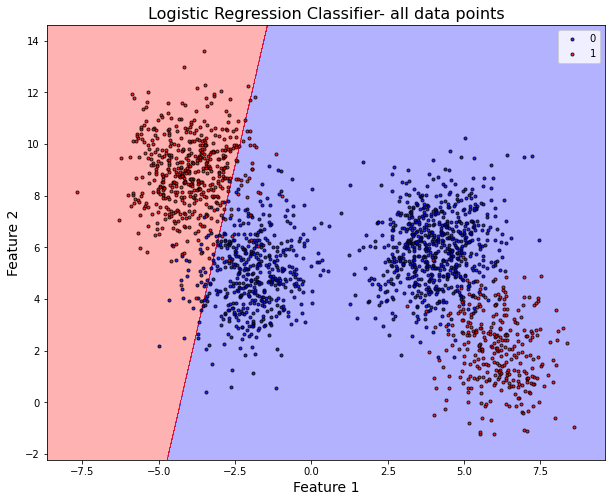

In [18]:
plot_decision_regions(X_training, y_training, LR_Classifier, resolution=0.01)
plt.xlabel('Feature 1', fontsize = 14)
plt.ylabel('Feature 2', fontsize = 14)
plt.title('Logistic Regression Classifier- all data points', size = 16)
plt.legend();

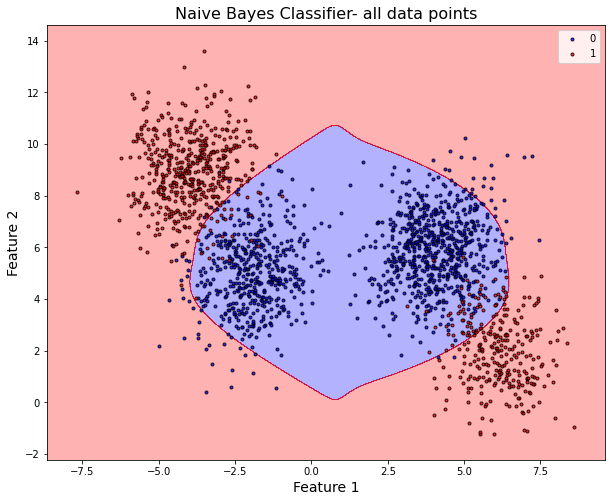

In [19]:
plot_decision_regions(X_training, y_training, NB_Classifier, resolution=0.01)
plt.xlabel('Feature 1', fontsize = 14)
plt.ylabel('Feature 2', fontsize = 14)
plt.title('Naive Bayes Classifier- all data points', size = 16)
plt.legend();

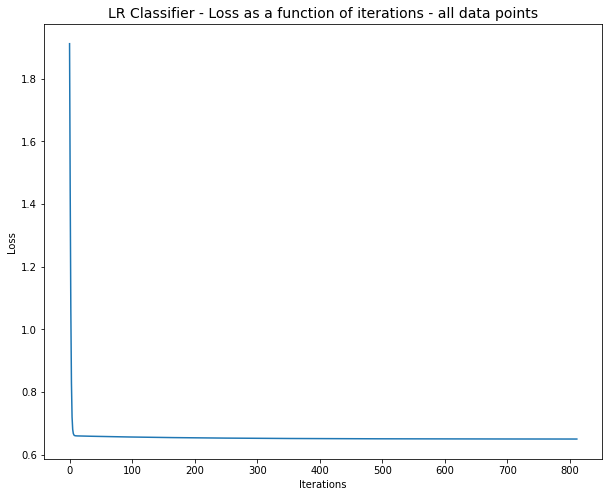

In [20]:
plt.plot(np.arange(len(LR_Classifier.J_history)), LR_Classifier.J_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('LR Classifier - Loss as a function of iterations - all data points', fontsize = 14);

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


In [21]:
from scipy.stats import multivariate_normal

In [22]:
# Creating data for when LR is better than NB - the two classes are linear seperable but the features are highly dependent 
cov = np.array([[2. , 2. , 2. ],
              [2. , 2, 2.  ],
              [2. , 2. , 2. ]])
class0_set = multivariate_normal.rvs([0,0,0], cov, 1000)
class1_set = class0_set.copy()
class1_set[:,2] = class1_set[:,2] + 4 
zeros = np.zeros(1000)
ones = np.ones(1000)
class1_set = np.c_[class1_set, ones]
class0_set= np.c_[class0_set, zeros]
multi_training = np.concatenate((class1_set, class0_set))
np.random.shuffle(multi_training) 

In [23]:
# Creating data for when LR is better than NB - the two classes are linear seperable but the features are highly dependent 
cov = np.array([[1.5 , 1.6 , 1.7 ],
                [1.6 , 1.5  , 1.4 ],
                [1.7 , 1.4 , 1.5 ]]) + 200
class0_set = multivariate_normal.rvs([0,0,0], cov, 1000)
class1_set = class0_set.copy()
class1_set[:,2] = class1_set[:,2] + 4 
zeros = np.zeros(1000)
ones = np.ones(1000)
class1_set = np.c_[class1_set, ones]
class0_set= np.c_[class0_set, zeros]
multi_training = np.concatenate((class1_set, class0_set))
np.random.shuffle(multi_training) 

In [24]:
# Creating data for when NB is better than LR - the classes are linear Inseparable 
v = np.array([[1 ,0 , 0 ],
              [0 , 1, 0  ],
              [0 , 0 , 1 ]])
NB_class1_set= multivariate_normal.rvs([0,0,0], v, 500)
NB_class0_set= multivariate_normal.rvs([3,3,3], v, 500)
NB_class0_set2 = multivariate_normal.rvs([-3,-3,-3], v, 500)
ones = np.ones(500).astype(int)
zeros = np.zeros(500).astype(int)
NB_class1_set = np.c_[NB_class1_set, ones]
NB_class0_set= np.c_[NB_class0_set, zeros]
NB_class0_set2 = np.c_[NB_class0_set2, zeros]
NB_multi_training = np.concatenate((NB_class1_set, NB_class0_set, NB_class0_set2))
np.random.shuffle(NB_multi_training)

<IPython.core.display.Javascript object>


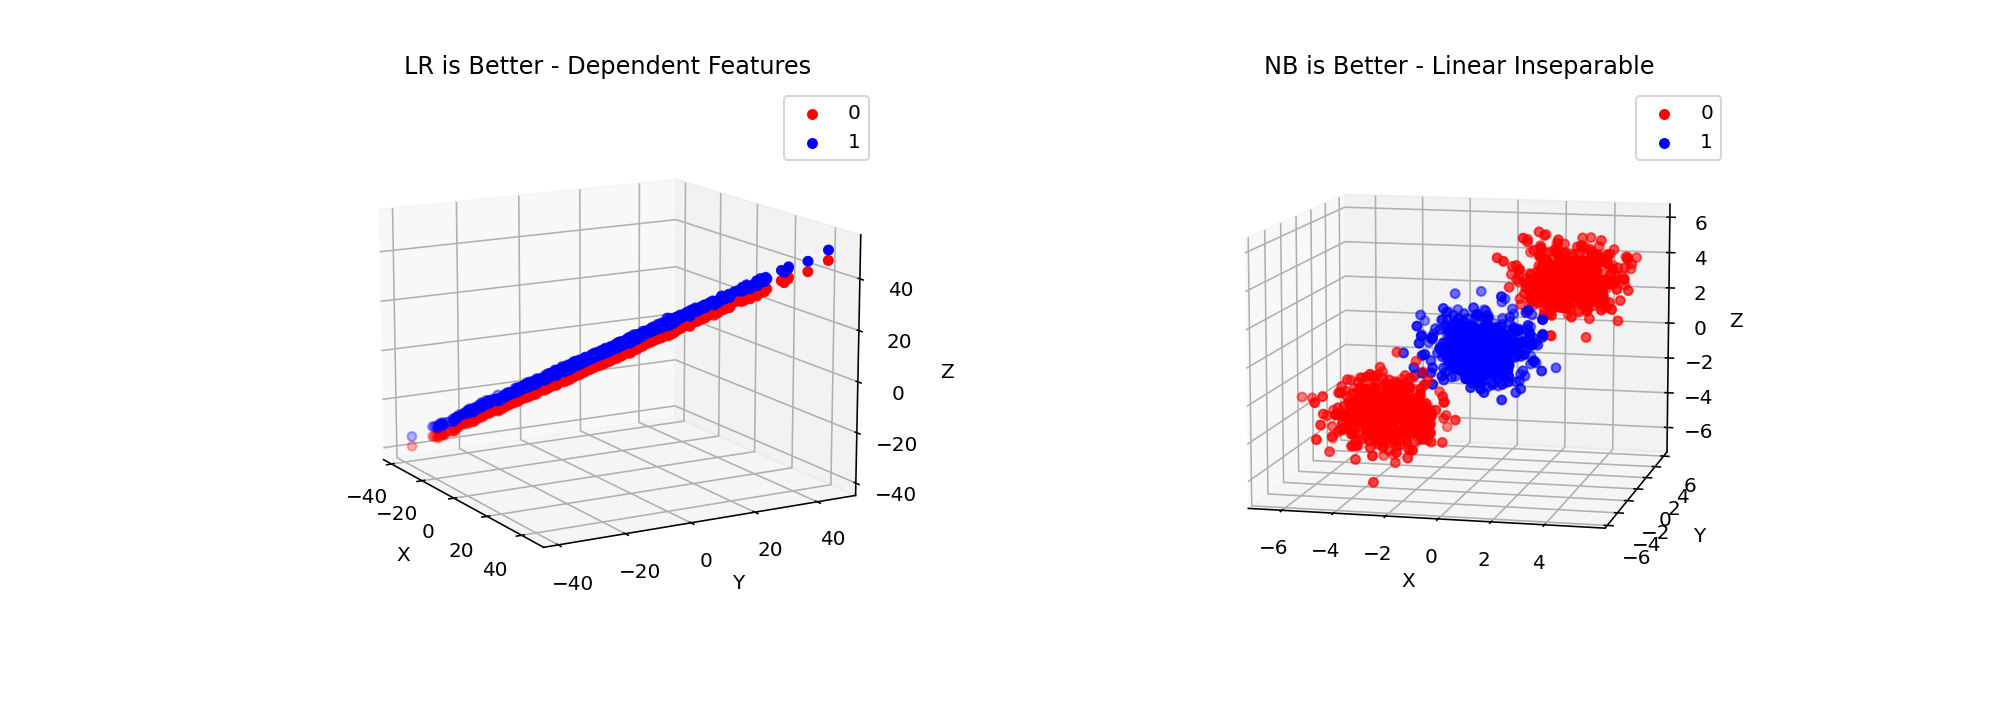

In [25]:
%matplotlib notebook
fig = plt.figure(figsize = (14,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(xs = class0_set[:,0], ys = class0_set[:,1], zs = class0_set[:,2] , color='r', label='0')
ax.scatter(xs = class1_set[:,0], ys = class1_set[:,1], zs = class1_set[:,2] , color='b', label='1')
ax.set_title("LR is Better - Dependent Features")
ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
plt.legend()
plt.show()
ax = fig.add_subplot(122, projection='3d')
ax.scatter(xs = NB_class0_set[:,0], ys = NB_class0_set[:,1], zs = NB_class0_set[:,2] , color='r', label='0')
ax.scatter(xs = NB_class1_set[:,0], ys = NB_class1_set[:,1], zs = NB_class1_set[:,2] , color='b', label='1')
ax.scatter(xs = NB_class0_set2[:,0], ys = NB_class0_set2[:,1], zs = NB_class0_set2[:,2] , color='r')
ax.set_title("NB is Better - Linear Inseparable")
ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
plt.legend();

In [26]:
LR_Classifier = LogisticRegressionGD(eta = best_eta, eps = best_eps)
LR_Classifier.fit(multi_training[:1500,:3], multi_training[:1500,3])
print(f"The accuracy of the Logistic Regression Classifier is: {LR_Classifier.accuracy(multi_training[1500:,:3], multi_training[1500:,3])}")

The accuracy of the Logistic Regression Classifier is: 1.0


In [27]:
NB_Classifier = NaiveBayesGaussian(k=2)
NB_Classifier.fit(multi_training[:1500,:3], multi_training[:1500,3])

print(f"The accuracy of the Naive Bayes Classifier is: {NB_Classifier.accuracy(multi_training[1500:,:3], multi_training[1500:,3])}")

The accuracy of the Naive Bayes Classifier is: 0.516


In [28]:
LR_Classifier = LogisticRegressionGD(eta = best_eta, eps = best_eps)
LR_Classifier.fit(NB_multi_training[:1000,:3], NB_multi_training[:1000,3])
print(f"The accuracy of the Logistic Regression Classifier is: {LR_Classifier.accuracy(NB_multi_training[500:,:3], NB_multi_training[500:,3])}")

The accuracy of the Logistic Regression Classifier is: 0.665


In [29]:
NB_Classifier = NaiveBayesGaussian(k=3)
NB_Classifier.fit(NB_multi_training[:1000,:3], NB_multi_training[:1000,3])
# NB_Classifier.accuracy(NB_multi_training[500:,:3], NB_multi_training[500:,3])
print(f"The accuracy of the Naive Bayes Classifier is: {NB_Classifier.accuracy(NB_multi_training[500:,:3], NB_multi_training[500:,3])}")

The accuracy of the Naive Bayes Classifier is: 0.967
